In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

# https://arxiv.org/pdf/2006.11239.pdf

import torch
from torch import optim, nn

from tqdm import tqdm
from random import randint

from load_dataset import load_dataset, plot_image
from UNet import UNet
from torchvision.transforms import v2
from matplotlib import pyplot as plt

device = "cuda"

pimages = load_dataset().to(device)
pimages.shape

torch.Size([3, 386, 3, 64, 64])

In [2]:
T = 500
beta = torch.linspace(10e-4, 0.02, T, device=device)

alpha = 1 - beta

alpha_ = torch.zeros(T, device=device)

for i in range(T):
    alpha_[i] = torch.prod(alpha[0:i+1])

alpha_[-1]

tensor(0.0051, device='cuda:0')

In [3]:
alpha_

tensor([0.9990, 0.9980, 0.9969, 0.9958, 0.9946, 0.9934, 0.9922, 0.9910, 0.9897,
        0.9883, 0.9870, 0.9856, 0.9841, 0.9827, 0.9812, 0.9796, 0.9781, 0.9764,
        0.9748, 0.9731, 0.9714, 0.9697, 0.9679, 0.9661, 0.9642, 0.9623, 0.9604,
        0.9585, 0.9565, 0.9545, 0.9524, 0.9503, 0.9482, 0.9461, 0.9439, 0.9417,
        0.9395, 0.9372, 0.9349, 0.9326, 0.9303, 0.9279, 0.9255, 0.9230, 0.9206,
        0.9181, 0.9155, 0.9130, 0.9104, 0.9078, 0.9052, 0.9025, 0.8998, 0.8971,
        0.8943, 0.8916, 0.8888, 0.8860, 0.8831, 0.8803, 0.8774, 0.8744, 0.8715,
        0.8685, 0.8656, 0.8626, 0.8595, 0.8565, 0.8534, 0.8503, 0.8472, 0.8440,
        0.8409, 0.8377, 0.8345, 0.8313, 0.8281, 0.8248, 0.8215, 0.8182, 0.8149,
        0.8116, 0.8083, 0.8049, 0.8015, 0.7981, 0.7947, 0.7913, 0.7878, 0.7844,
        0.7809, 0.7774, 0.7739, 0.7704, 0.7669, 0.7633, 0.7598, 0.7562, 0.7526,
        0.7490, 0.7454, 0.7418, 0.7382, 0.7346, 0.7309, 0.7273, 0.7236, 0.7199,
        0.7163, 0.7126, 0.7089, 0.7052, 

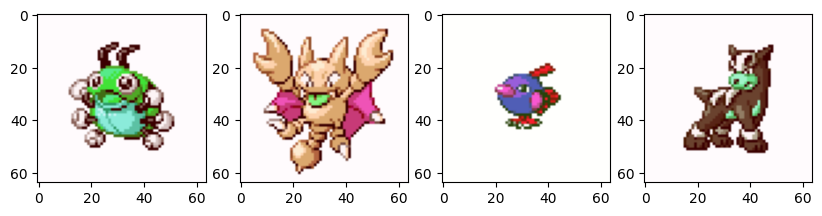

In [4]:
transform = v2.Compose([
    v2.ColorJitter(),
    v2.RandomChannelPermutation(),
    v2.RandomGrayscale(p = 0.1),
    #v2.GaussianBlur(kernel_size=9, sigma=(1,1))
])

source = randint(0, 2)
batch = torch.randperm(385)[:4]
x0 = pimages[source, batch]
x0 = torch.stack([transform(x) for x in x0], dim=0)

fig, axes = plt.subplots(1, 4, figsize=(10, 10))
plot_image(x0[0], axes[0])
plot_image(x0[1], axes[1])
plot_image(x0[2], axes[2])
plot_image(x0[3], axes[3])
plt.show()

In [5]:
model = UNet(3, 3).to(device)

@torch.no_grad
def generate_image():
    model.eval()

    x = torch.randn((3,64,64), device=device)

    for t in reversed(range(T)):
        tt = torch.tensor(t, device=device)

        z = torch.randn((3,64,64), device=device)
        e = model(x[None], tt)[0] * (1 - alpha[t]) / torch.sqrt(1 - alpha_[t])

        x = (1 / torch.sqrt(alpha[t])) * (x - e) + z * torch.sqrt(beta[t])
        
    plot_image(x)
    plt.show()

    model.train()

  0%|          | 0/10001 [00:00<?, ?it/s]

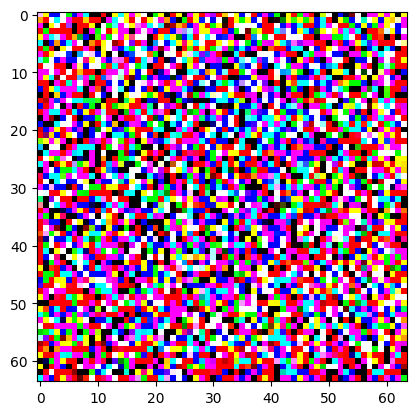

0.18818304:   5%|▍         | 499/10001 [00:39<11:36, 13.64it/s]

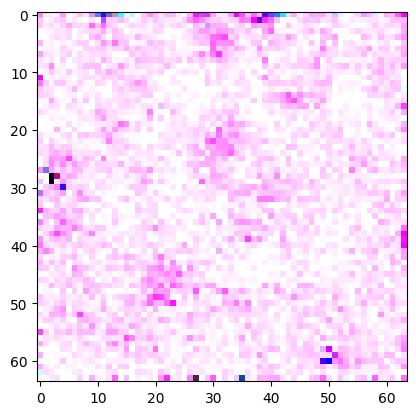

0.05271385:  10%|▉         | 999/10001 [01:19<11:03, 13.56it/s]  

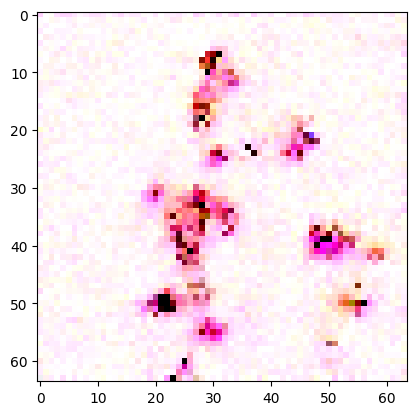

0.09932767:  15%|█▍        | 1499/10001 [01:59<10:28, 13.53it/s]  

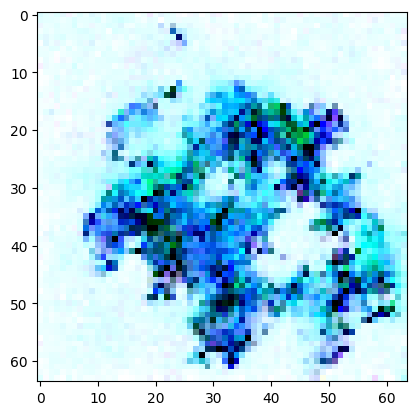

0.09595420:  20%|█▉        | 1999/10001 [02:38<09:51, 13.53it/s]  

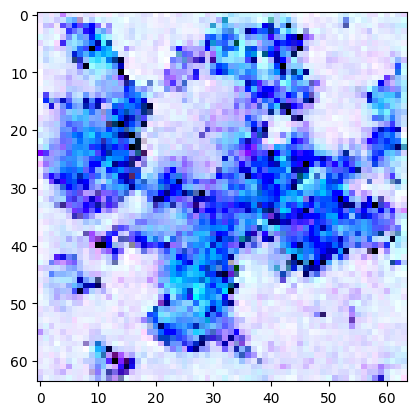

0.07077869:  25%|██▍       | 2499/10001 [03:18<09:16, 13.48it/s]  

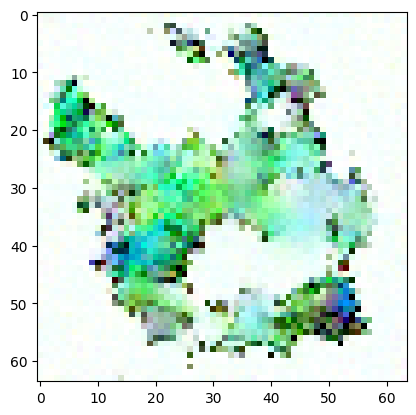

0.10248792:  30%|██▉       | 2999/10001 [03:58<08:29, 13.73it/s]  

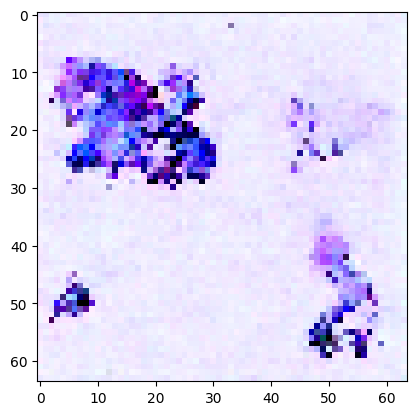

0.07802999:  35%|███▍      | 3499/10001 [04:38<07:59, 13.56it/s]

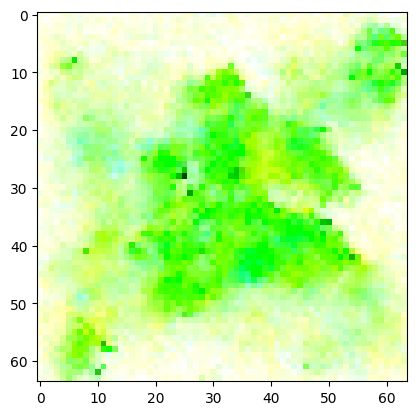

0.04923590:  40%|███▉      | 3999/10001 [05:18<07:22, 13.55it/s]

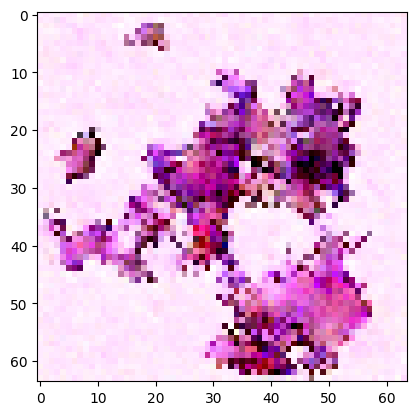

0.09333318:  45%|████▍     | 4499/10001 [05:58<06:52, 13.34it/s]

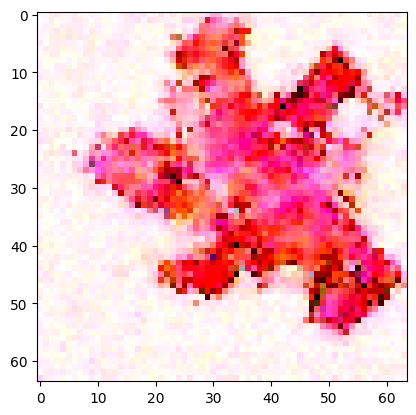

0.06503953:  50%|████▉     | 4999/10001 [06:37<06:09, 13.55it/s]

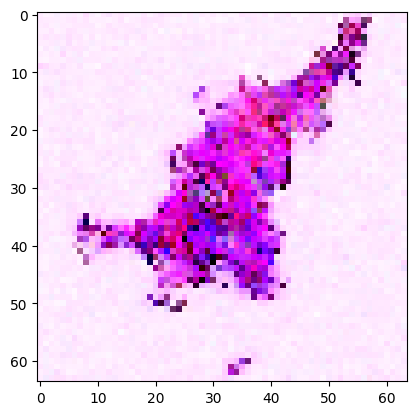

0.08056122:  55%|█████▍    | 5499/10001 [07:17<05:31, 13.56it/s]

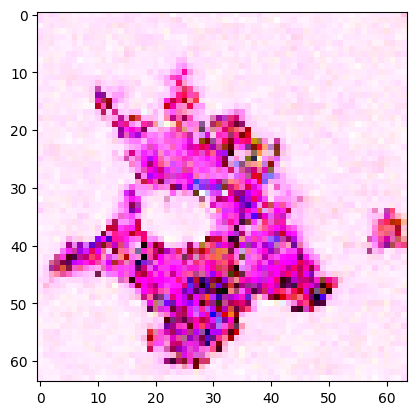

0.05439825:  60%|█████▉    | 5999/10001 [07:57<04:54, 13.59it/s]

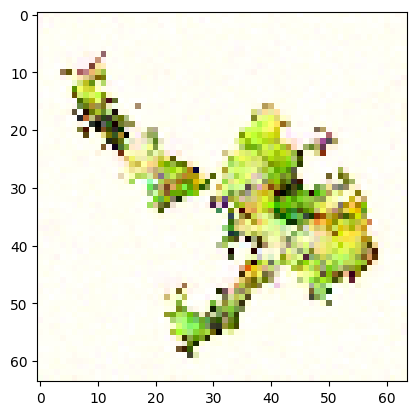

0.06859274:  65%|██████▍   | 6499/10001 [08:36<04:18, 13.56it/s]

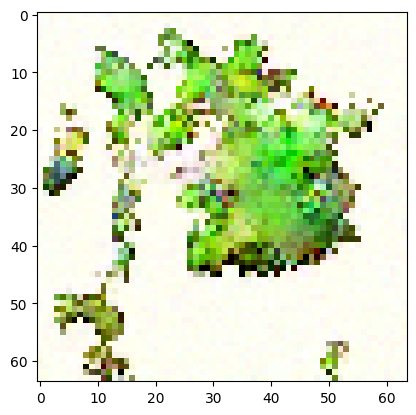

0.07576631:  70%|██████▉   | 6999/10001 [09:16<03:41, 13.58it/s]

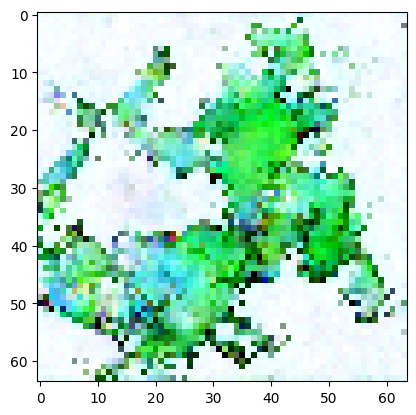

0.09131324:  75%|███████▍  | 7499/10001 [09:56<03:04, 13.55it/s]

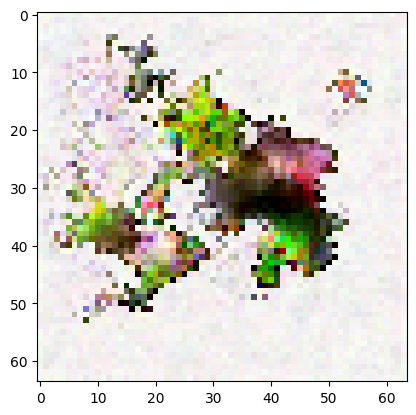

0.05038423:  80%|███████▉  | 7999/10001 [10:35<02:27, 13.56it/s]

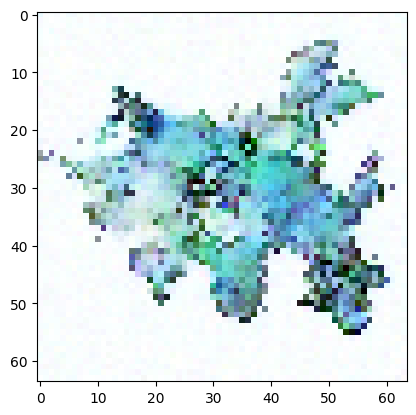

0.04592672:  85%|████████▍ | 8499/10001 [11:15<01:50, 13.54it/s]

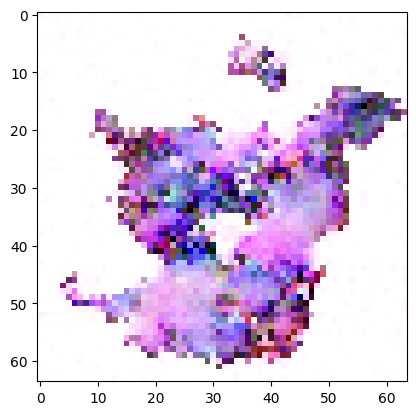

0.07787477:  90%|████████▉ | 8999/10001 [11:55<01:14, 13.54it/s]

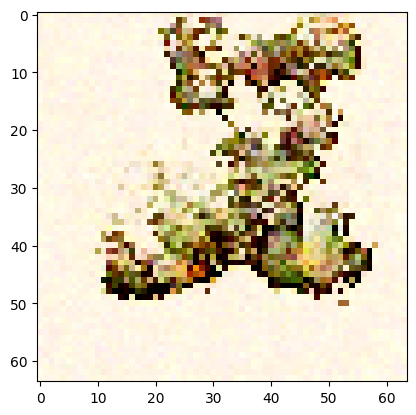

0.06427839:  95%|█████████▍| 9499/10001 [12:34<00:37, 13.56it/s]

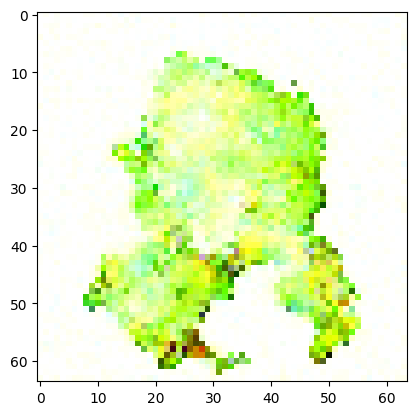

0.05853578: 100%|█████████▉| 9999/10001 [13:14<00:00, 13.56it/s]

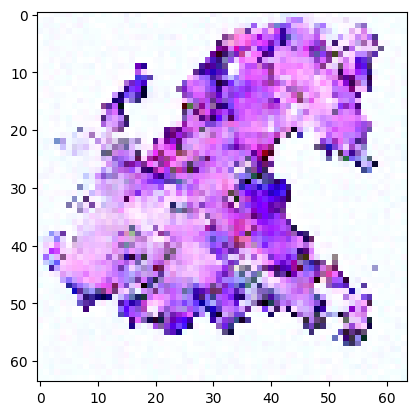

0.04269239: 100%|██████████| 10001/10001 [13:17<00:00, 12.54it/s]


In [6]:
loss_func = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
    
pbar = tqdm(range(10001))#, miniters=15)
def closure():
    optimizer.zero_grad()

    bs = 8

    source = randint(0, 2)
    batch = torch.randperm(385)[:bs]
    x0 = pimages[source, batch]
    x0 = torch.stack([transform(x) for x in x0], dim=0)
    
    e = torch.randn(x0.shape, device=device)
    t = torch.randint(0, T - 1, (bs,), device=device)

    x_nois = torch.sqrt(alpha_[t])[:, None, None, None] * x0 + torch.sqrt(1-alpha_[t])[:, None, None, None] * e
    e_pred = model(x_nois, t)

    # Calculate the loss between the result and the noise
    loss = loss_func(e, e_pred)
    loss.backward()
    
    pbar.set_description(f"%.8f" % loss, refresh=False)
    
    return loss

model.train()
for j in pbar:
    optimizer.step(closure)

    if j % 500 == 0:
        generate_image()

torch.save(model.state_dict(), 'model.pt')